# Набор данных о кино-индустрии
- Предметная область: Индустрия кино. Анализ финансовых показателей проката, популярности жанров, прогнозирование доходов
- Источник: https://www.kaggle.com/datasets/danielgrijalvas/movies
- Тип данных: Реальные данные 7000+ фильмов за 1986-2020 года с ресурса IMDb

Набор применим для:
- Регрессии: Прогнозирования доходности проката фильма на основе доступных данных
- Кластеризация: по бюджету и дохода фильма, по рейтингу

Признаки:

| Тип данных | Признак | Описание                     |
|------------|---------|------------------------------|
| name       | string  | Название фильма              |
| rating     | string  | Возрастной рейтинг           |
| genre      | string  | Жанр                         |
| year       | int64   | Год выпуска                  |
| released   | string  | Дата и место первого проката |
| score      | float64 | Рейтинг IMDb                 |
| votes      | float64 | Количество голосов           |
| director   | string  | Режиссёр                     |
| writer     | string  | Сценарист                    |
| star       | string  | Главный актёр                |
| country    | string  | Страна                       |
| budget     | float64 | Бюджет                       |
| gross      | float64 | Доход                        |
| company    | string  | Продюсер                     |
| runtime    | float64 | Продолжительность в минутах  |

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from typing import Optional

In [221]:
df = pd.read_csv('raw/movies/movies.csv')
df.drop('released', axis=1)
df.sample(10, random_state=228)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
2494,North,PG,Adventure,1994,"July 22, 1994 (United States)",4.5,13000.0,Rob Reiner,Alan Zweibel,Elijah Wood,United States,40000000.0,7182747.0,Castle Rock Entertainment,87.0
4126,The Good Girl,R,Drama,2002,"August 30, 2002 (United States)",6.4,44000.0,Miguel Arteta,Mike White,Jennifer Aniston,United States,8000000.0,16860964.0,Flan de Coco Films,93.0
5649,Kick-Ass,R,Action,2010,"April 16, 2010 (United States)",7.6,535000.0,Matthew Vaughn,Jane Goldman,Aaron Taylor-Johnson,United Kingdom,30000000.0,96188903.0,Marv Films,117.0
3382,Dead Man on Campus,R,Comedy,1998,"August 21, 1998 (United States)",6.0,14000.0,Alan Cohn,Anthony Abrams,Tom Everett Scott,United States,14000000.0,15064946.0,Paramount Pictures,96.0
1573,Tap,PG-13,Comedy,1989,"February 10, 1989 (United States)",6.5,1500.0,Nick Castle,Nick Castle,Gregory Hines,United States,NaN,9114702.0,Beco Films,111.0
7486,Anna,R,Action,2019,"June 21, 2019 (United States)",6.6,69000.0,Luc Besson,Luc Besson,Sasha Luss,France,NaN,31626978.0,Summit Entertainment,118.0
4640,Clifford's Really Big Movie,G,Animation,2004,"April 23, 2004 (United States)",5.4,822.0,Robert C. Ramirez,Rhett Reese,John Ritter,United States,70000.0,3255426.0,Big Red Dog Productions,74.0
2690,While You Were Sleeping,PG,Comedy,1995,"April 21, 1995 (United States)",6.7,95000.0,Jon Turteltaub,Daniel G. Sullivan,Sandra Bullock,United States,17000000.0,182057016.0,Hollywood Pictures,103.0
5337,Miss Pettigrew Lives for a Day,PG-13,Comedy,2008,"March 7, 2008 (United States)",7.1,27000.0,Bharat Nalluri,David Magee,Frances McDormand,United Kingdom,NaN,16724933.0,Focus Features,92.0
932,Lady Jane,PG-13,Biography,1986,"February 7, 1986 (United States)",7.1,6300.0,Trevor Nunn,Chris Bryant,Helena Bonham Carter,United Kingdom,8500000.0,277646.0,Capital Equipment Leasing,136.0


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Видно, что многие целочисленные признаки считались как вещественные. Поправим это

In [223]:
# Convert real values to integers if necessary.
float_features = df.select_dtypes(include='float64').columns
float_features = float_features.dropna()
for feature in float_features:
    func = lambda x: pd.isna(x) or (pd.notna(x) and x.is_integer())
    if df[feature].apply(func).all():
        df[feature] = df[feature].astype('Int64')

Год выпуска (year) часто не совпадает с годом первого показа из released, хотя последний является более важным признаком.

Заменим значения year на год из released, если возможно, а released можно будет удалить

In [224]:
regex = r'(\w+) (\d+), (\d+) \((.+)\)'
for value in df['released']:
    if not re.match(regex, str(value)):
        print(value)

df[df['released'].isna()]

November 1980 (United Kingdom)
1981 (United States)
1982 (Japan)
October 1982 (United States)
March 1992 (United States)
January 1983 (United Kingdom)
August 1983 (United States)
February 1984 (United States)
March 1985 (United States)
September 1987 (United States)
March 1986 (United States)
1985 (Taiwan)
1985 (United States)
October 1986 (United States)
February 1987 (United States)
April 1986 (United States)
1987 (United States)
May 1988 (United Kingdom)
September 1987 (United States)
June 1991 (United States)
May 1989 (United States)
May 1988 (United States)
August 1988 (United States)
October 1988 (United States)
October 1988 (United States)
June 1988 (United States)
March 1989 (United States)
July 1989 (United States)
June 1990 (United States)
April 1990 (United States)
May 1990 (United States)
April 1991 (United States)
April 1991 (United States)
December 1991 (United States)
March 1991 (United States)
April 1991 (United States)
January 1991 (United States)
August 1991 (United S

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,<NA>,<NA>,NaN,<NA>
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,<NA>,<NA>,NaN,<NA>


Имеем значения вида '...{year} ({country})' и два вхождения с NaN, которые вскоре всё равно будут удалены, ведь по ним слишком мало информации

In [225]:
def released_to_year(val_str: str) -> Optional[int]:
    val_str = val_str.split('(')[0].strip()
    return int(val_str[-4:])


func = lambda x: released_to_year(x['released']) if str(x['released']) != 'nan' else x['year']
df['year'] = df.apply(func, axis=1)
df = df.drop('released', axis=1)

In [226]:
# Show how many NaN values are in the table.
columns = df.columns
total_rows = df.shape[0]
no_misses_rows = []
for col in columns:
    nan_count = df[col].isna().sum()
    not_empty = df[col].count()
    if not_empty == total_rows:
        no_misses_rows.append(col)
    else:
        print(f'{col}: NaN={nan_count}, Values={not_empty} of {total_rows} rows')
print(f'Cols without any NaN/Empty: {', '.join(no_misses_rows)}')

rating: NaN=77, Values=7591 of 7668 rows
score: NaN=3, Values=7665 of 7668 rows
votes: NaN=3, Values=7665 of 7668 rows
writer: NaN=3, Values=7665 of 7668 rows
star: NaN=1, Values=7667 of 7668 rows
country: NaN=3, Values=7665 of 7668 rows
budget: NaN=2171, Values=5497 of 7668 rows
gross: NaN=189, Values=7479 of 7668 rows
company: NaN=17, Values=7651 of 7668 rows
runtime: NaN=4, Values=7664 of 7668 rows
Cols without any NaN/Empty: name, genre, year, director


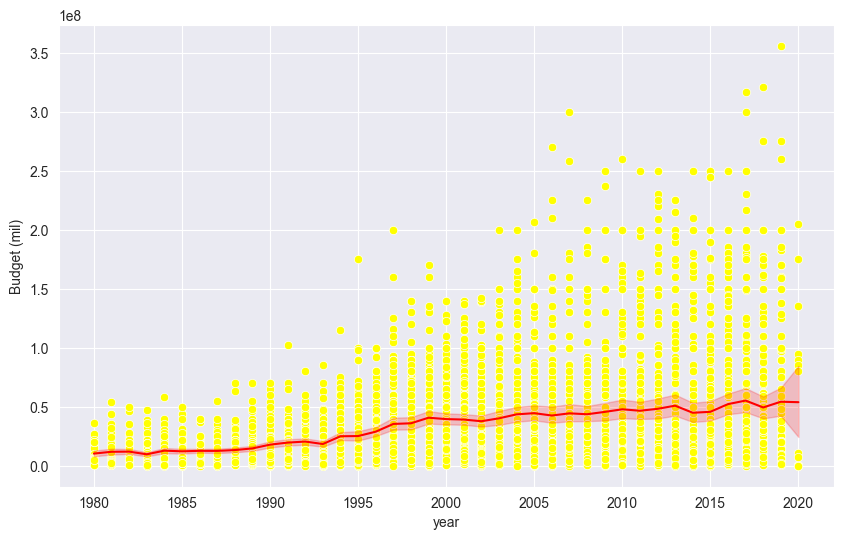

In [227]:
# Show distribution between budget & year.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='budget', color='yellow')
sns.lineplot(data=df, x='year', y='budget', color='red')
plt.ylabel('Budget (mil)')
plt.show()

С годами бюджет фильмов растёт. Попробуем заменить NaN на медианные значения бюджета, опираясь на годовые показатели

In [228]:
# Replace budget NaN values 
mean_per_year = df.groupby('year')['budget'].transform('mean').astype('Int64')
df['budget'] = df['budget'].fillna(mean_per_year)
print('NaN values left:', df.isna().sum().sum())
df.isna().sum().sort_values(ascending=False)

NaN values left: 300


gross       189
rating       77
company      17
runtime       4
score         3
votes         3
country       3
writer        3
star          1
name          0
genre         0
year          0
director      0
budget        0
dtype: int64

Записи с неопределенными показателями дохода можно удалить за ненадобностью, останется относительно мало включений с NaN - их тоже можно удалить

In [229]:
df = df.dropna()
print('NaN values left:', df.isna().sum().sum())

NaN values left: 0


### Анализ и визуализация

In [230]:
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
2817,Georgia,R,Drama,1995,6.6,2800,Ulu Grosbard,Barbara Turner,Jennifer Jason Leigh,France,25143826,1110104,CiBy 2000,115
4265,Terminator 3: Rise of the Machines,R,Action,2003,6.3,383000,Jonathan Mostow,John Brancato,Arnold Schwarzenegger,United States,200000000,433371112,C-2 Pictures,109
5175,The Comebacks,PG-13,Comedy,2007,4.3,11000,Tom Brady,Ed Yeager,David Koechner,United States,20000000,13539154,Fox Atomic,84
5196,The Great Debaters,PG-13,Biography,2007,7.5,57000,Denzel Washington,Robert Eisele,Denzel Washington,United States,15000000,30271556,Harpo Films,126
5441,The Family That Preys,PG-13,Drama,2008,5.8,6800,Tyler Perry,Tyler Perry,Kathy Bates,United States,43632738,37105289,Louisiana Producers Film Source,111
5009,Bobby,R,Biography,2006,7.0,41000,Emilio Estevez,Emilio Estevez,Anthony Hopkins,United States,14000000,20718608,The Weinstein Company,117
5700,Hot Tub Time Machine,R,Comedy,2010,6.4,165000,Steve Pink,Josh Heald,John Cusack,United States,36000000,64780213,Metro-Goldwyn-Mayer (MGM),101
5862,Warrior,PG-13,Action,2011,8.1,445000,Gavin O'Connor,Gavin O'Connor,Tom Hardy,United States,25000000,23308615,Lionsgate,140
452,Lovesick,PG,Comedy,1983,5.2,747,Marshall Brickman,Marshall Brickman,Dudley Moore,United States,10100000,10171304,The Ladd Company,95
5231,Boarding Gate,R,Drama,2007,5.1,3600,Olivier Assayas,Olivier Assayas,Asia Argento,France,44402981,586888,Canal+,106


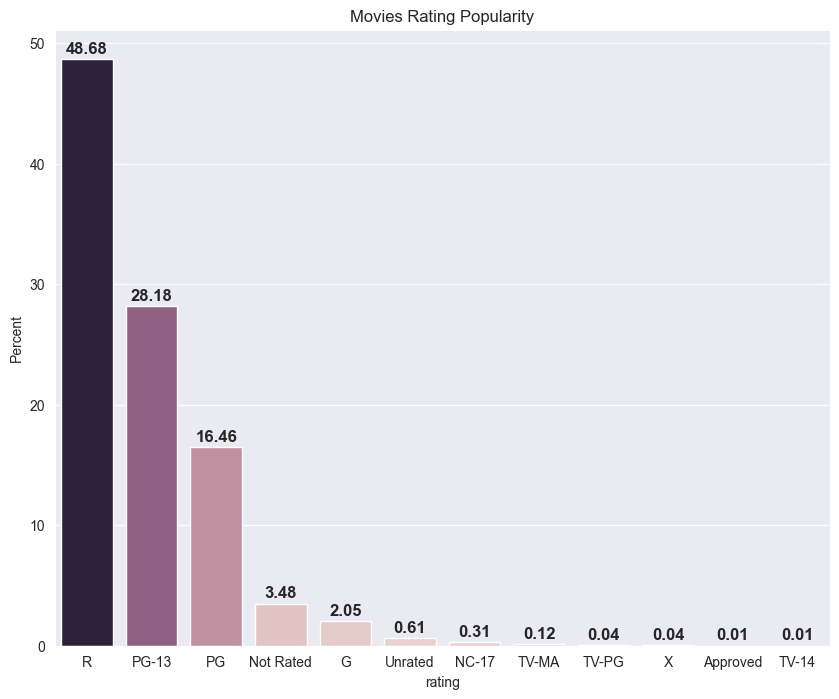

In [231]:
# G - General Audiences (no restrictions).
# PG - Parental Guidance Suggested
# PG-13 - 13+
# R - 17+
# NC-17 - 18+

data = df['rating'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data.index, y=data,
    hue=data, legend=False
)
plt.ylabel('Percent')
plt.title(f'Movies Rating Popularity')
for ind, val in enumerate(data):
    ax.annotate(
        f'{val:.2f}', xy=(ind, val+0.5), ha='center',
        fontsize=12, fontweight='bold'
    )

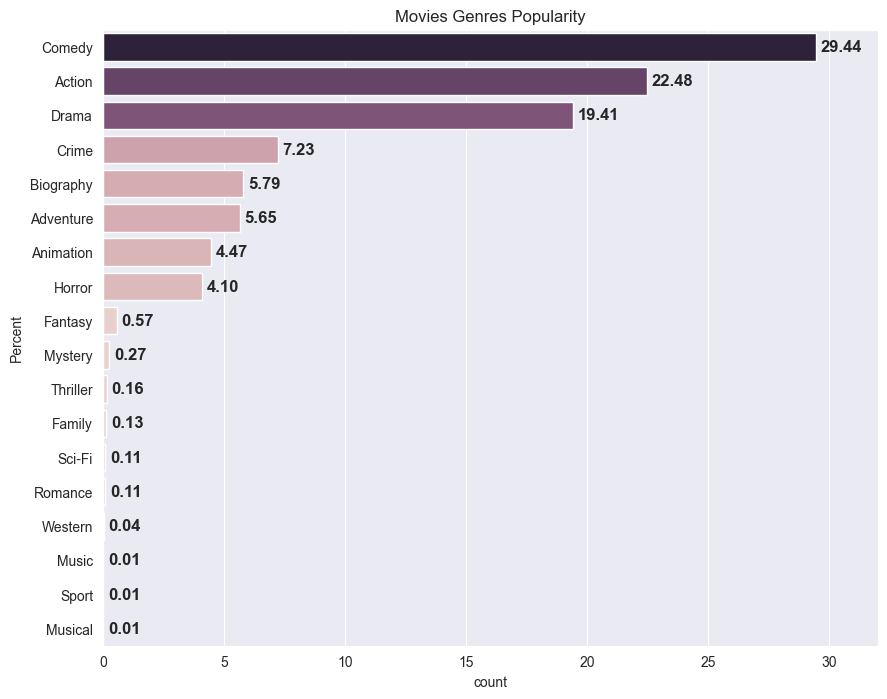

In [232]:
data = df['genre'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 32)
plt.ylabel('Percent')
plt.title('Movies Genres Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

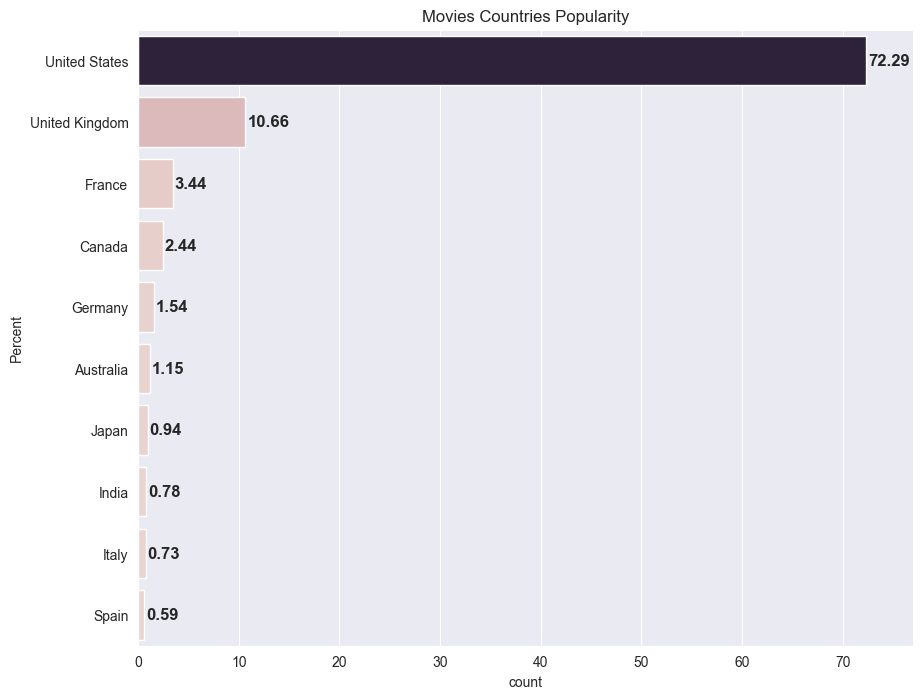

In [233]:
data = df['country'].value_counts()
data = round(data / sum(data) * 100, 2)
data = data[:10]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 77)
plt.ylabel('Percent')
plt.title('Movies Countries Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

Text(0.5, 1.0, 'Movies Release Year distribution')

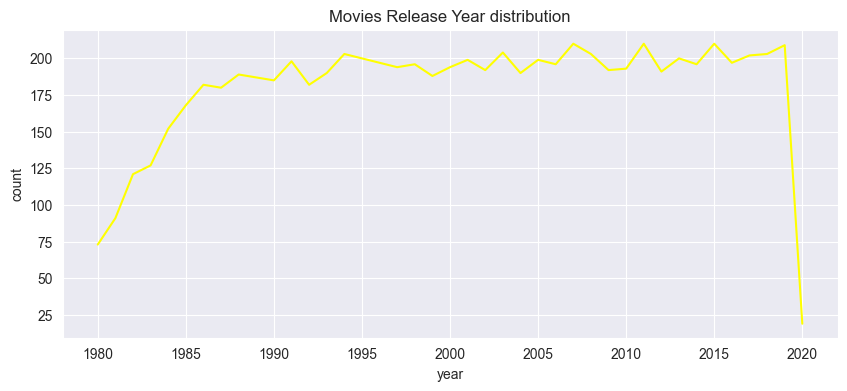

In [234]:
data = df['year'].value_counts()

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=data.index, y=data, color='yellow')
plt.title('Movies Release Year distribution')

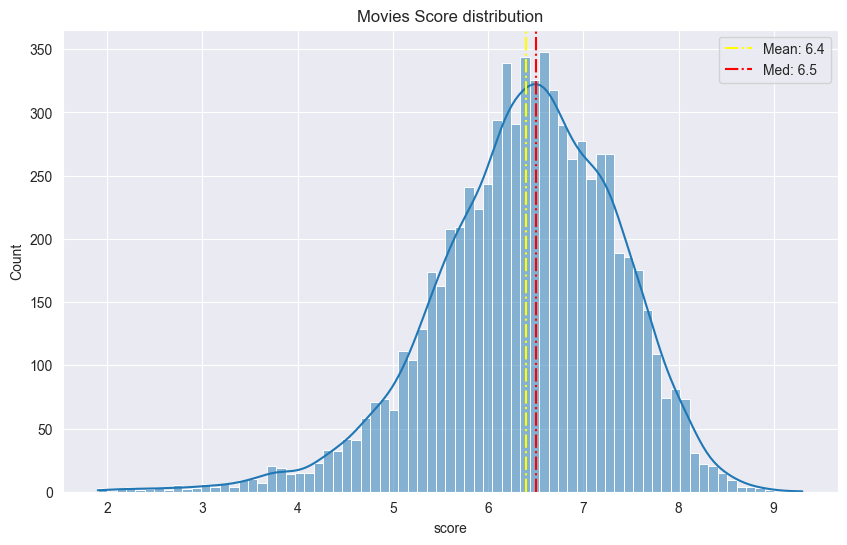

The score data skew: -0.61


In [235]:
data = df['score']

plt.figure(figsize=(10, 6))
plt.title('Movies Score distribution')

# Histogram
bins = 10 * (data.max() - data.min()) + 1
sns.histplot(data, kde=True, bins=int(bins))

# Median and Mean lines
mean, med = data.mean(), data.median()
plt.axvline(mean, color='yellow', linestyle='-.', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='red', linestyle='-.', label=f'Med: {med:.1f}')

plt.legend()
plt.show()

print(f'The score data skew: {df["score"].skew(): 0.2f}')

In [236]:
def print_top(df_col: pd.Series, param: str, count: int = 5) -> None:
    print(f'Top {count} {param} by number of movies')
    for k, v in df_col.value_counts().head(count).items():
        print(f'\t{k}: {v}')
    print()

print_top(df['director'], 'directors')
print_top(df['writer'], 'writers')
print_top(df['company'], 'companies')

Top 5 directors by number of movies
	Woody Allen: 38
	Clint Eastwood: 31
	Steven Spielberg: 27
	Directors: 25
	Ron Howard: 24

Top 5 writers by number of movies
	Woody Allen: 37
	Stephen King: 31
	Luc Besson: 25
	John Hughes: 25
	William Shakespeare: 15

Top 5 companies by number of movies
	Universal Pictures: 376
	Columbia Pictures: 332
	Warner Bros.: 332
	Paramount Pictures: 319
	Twentieth Century Fox: 240



In [237]:
print('Top 15 movies of all time (by IMDb rating)')
filtered = df['score'].nlargest(15)
df.loc[filtered.index, ['year', 'name', 'score']]

Top 15 movies of all time (by IMDb rating)


,year,name,score
2443,1994,The Shawshank Redemption,9.3
5243,2008,The Dark Knight,9.0
2247,1994,Schindler's List,8.9
2444,1994,Pulp Fiction,8.9
4245,2003,The Lord of the Rings: The Return of the King,8.9
2445,1994,Forrest Gump,8.8
3444,1999,Fight Club,8.8
3845,2001,The Lord of the Rings: The Fellowship of the Ring,8.8
5643,2010,Inception,8.8
2,1980,Star Wars: Episode V - The Empire Strikes Back,8.7


### Зависимости признаков. Матрица корреляции.

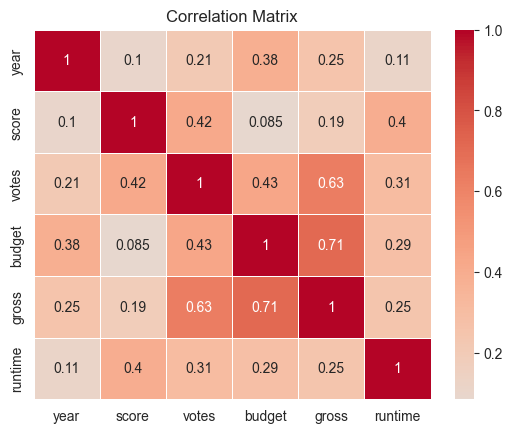

In [238]:
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Из матрицы видно:
1. Сильную положительную зависимость gross от budget = 0.71
2. Сильную положительную зависимость gross от votes  = 0.63

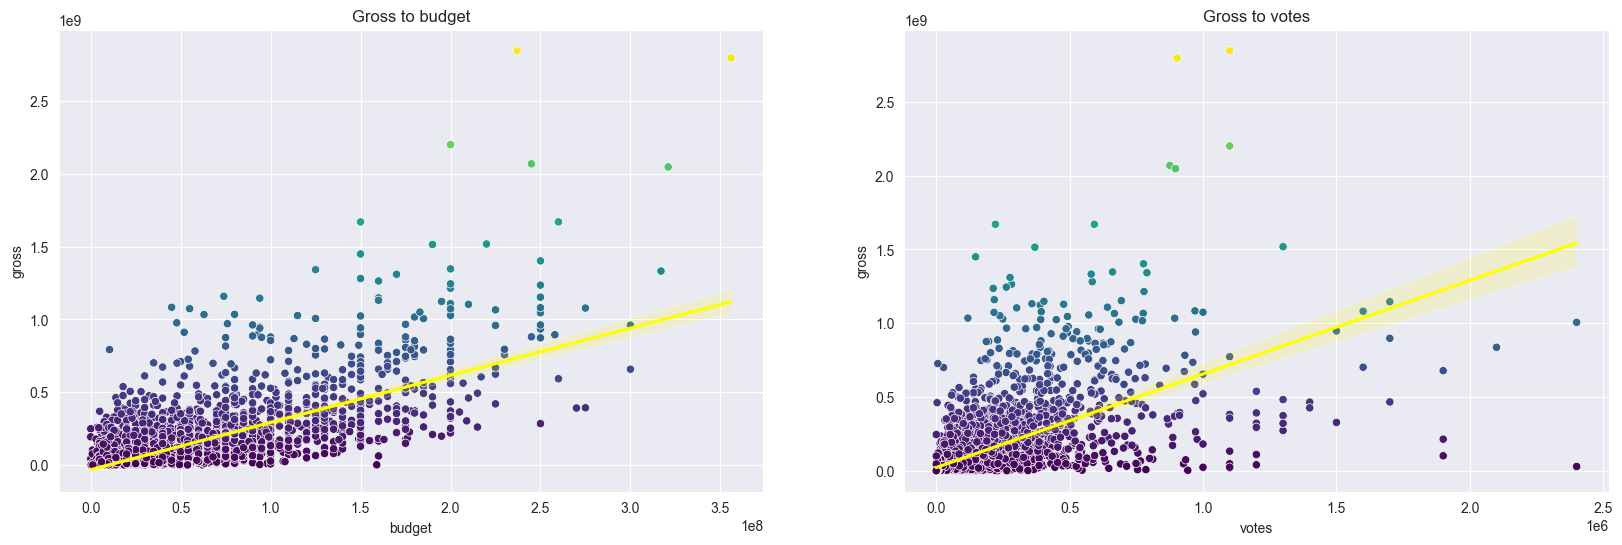

In [239]:
plt.figure(figsize=(20, 6))

# Plot 1: Gross/Budget.
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='budget', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to budget')

# Plot 2: Gross/Votes
plt.subplot(1, 2, 2)
sns.scatterplot(x='votes', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='votes', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to votes')

plt.show()

Выводы:
1. Чем сильнее растёт бюджет, тем больше доход;
2. Чем больше оценок (тем больше просмотрело людей), тем больше доход.

In [240]:
# New feature: profit.
df['profit'] = df['gross'] - df['budget']
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit
6860,La La Land,PG-13,Comedy,2016,8.0,527000,Damien Chazelle,Damien Chazelle,Ryan Gosling,United States,30000000,448906865,Summit Entertainment,128,418906865
4766,The Perfect Man,PG,Comedy,2005,5.5,29000,Mark Rosman,Michael McQuown,Hilary Duff,United States,10000000,19770475,Universal Pictures,100,9770475
6621,Effie Gray,PG-13,Biography,2014,6.0,4900,Richard Laxton,Emma Thompson,Dakota Fanning,United Kingdom,44890496,721143,Sovereign Films (II),104,-44169353
3370,"Crna macka, beli macor",R,Comedy,1998,8.1,52000,Emir Kusturica,Gordan Mihic,Bajram Severdzan,Federal Republic of Yugoslavia,35960134,351447,CiBy 2000,127,-35608687
6398,Snitch,PG-13,Action,2013,6.4,85000,Ric Roman Waugh,Justin Haythe,Dwayne Johnson,United States,15000000,57824674,Exclusive Media Group,112,42824674
6696,Straight Outta Compton,R,Biography,2015,7.8,185000,F. Gary Gray,Jonathan Herman,O'Shea Jackson Jr.,United States,28000000,201634991,Universal Pictures,147,173634991
7450,Joker,R,Crime,2019,8.4,1000000,Todd Phillips,Todd Phillips,Joaquin Phoenix,United States,55000000,1074427370,Warner Bros.,122,1019427370
2609,Sleep with Me,R,Comedy,1994,5.7,2500,Rory Kelly,Duane Dell'Amico,Craig Sheffer,United States,24979814,200151,August Entertainment,86,-24779663
459,Romantic Comedy,PG,Comedy,1983,5.2,786,Arthur Hiller,Bernard Slade,Dudley Moore,United States,9683984,6857733,Metrocolor,103,-2826251
5833,Hatchet II,R,Action,2010,5.5,13000,Adam Green,Adam Green,Danielle Harris,United States,800000,156190,ArieScope Pictures,85,-643810


### Категоризация, нормализация, подбор числа кластеров K-Means

In [241]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


# Encode labels
label_encoder = LabelEncoder()
categorical_features = ['rating', 'genre', 'country']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
# Get numerical features, normalize
df_numeric = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)

# Search for optimal k
k_range = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in k_range]
score = [kmeans[i-1].fit(df_numeric).score(df_numeric) for i in k_range]

### Кластеризация K-Means

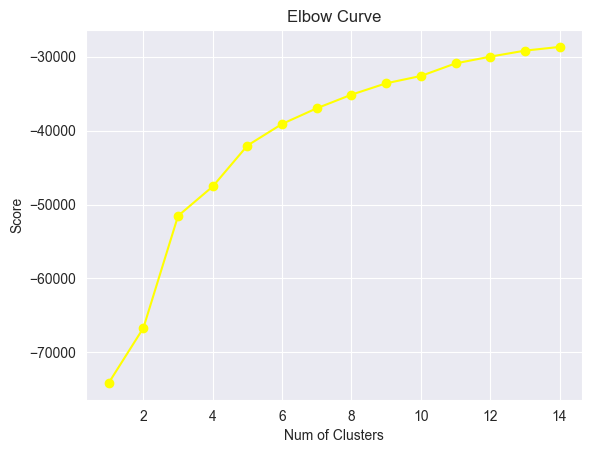

In [242]:
# Show kmeans
plt.plot(k_range, score, marker='o', color='yellow')
plt.xlabel('Num of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [243]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(df_numeric)
len(kmeans.labels_)

7412

In [244]:
df['cluster'] = kmeans.labels_
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,cluster
0,The Shining,6,6,1980,8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,52,19000000,46998772,Warner Bros.,146,27998772,0
1,The Blue Lagoon,6,1,1980,5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,53,4500000,58853106,Columbia Pictures,104,54353106,2
2,Star Wars: Episode V - The Empire Strikes Back,4,0,1980,8.7,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,53,18000000,538375067,Lucasfilm,124,520375067,3
3,Airplane!,4,4,1980,7.7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,53,3500000,83453539,Paramount Pictures,88,79953539,2
4,Caddyshack,6,4,1980,7.3,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,53,6000000,39846344,Orion Pictures,98,33846344,2


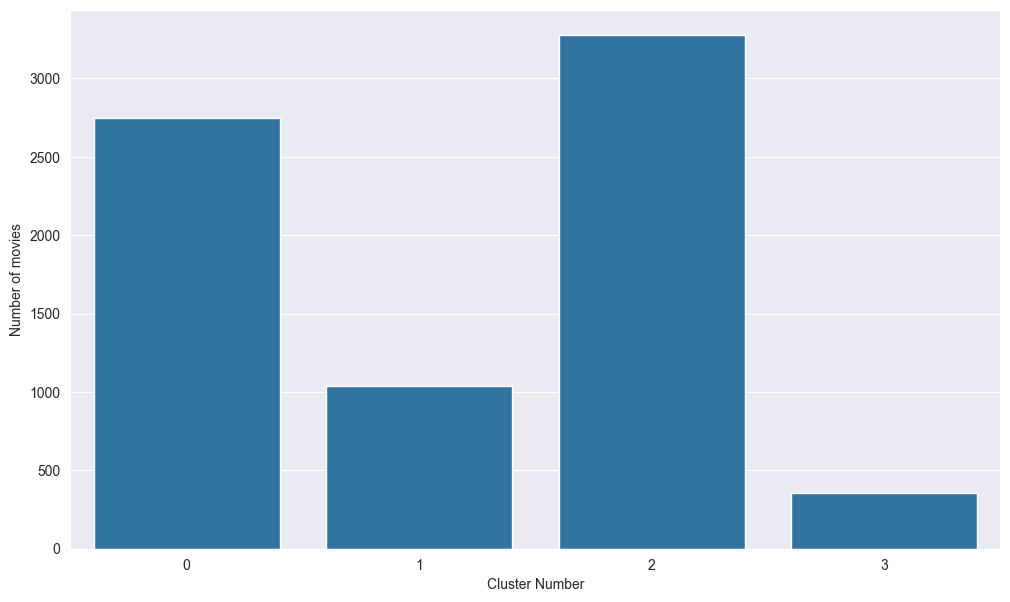

In [245]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,optimal_k,1),y=df.groupby(['cluster']).count()['budget'].values)
x=axis.set_xlabel("Cluster Number")
y=axis.set_ylabel("Number of movies")


In [246]:
df_numeric = df.select_dtypes(include=[np.number])
df_numeric = df_numeric.groupby('cluster').mean().round(2)

for cluster, count in df['cluster'].value_counts().sort_index().items():
    print(f'Cluster #{cluster} size: {count}')
    
df_numeric

Cluster #0 size: 2747
Cluster #1 size: 1035
Cluster #2 size: 3275
Cluster #3 size: 355


,rating,genre,year,score,votes,country,budget,gross,runtime,profit
cluster,,,,,,,,,,
0,5.32,3.22,2008.49,6.65,124463.69,52.42,42247106.85,88494619.86,111.88,46247513.01
1,5.05,3.75,2003.35,6.73,55885.78,14.04,31788884.38,32882982.55,111.8,1094098.17
2,5.20,4.00,1992.74,5.99,25117.42,52.57,17928221.84,23204301.02,100.41,5276079.18
3,4.71,1.30,2009.25,7.21,537285.92,51.06,134488681.69,654584557.73,125.38,520095876.04


Можно увидеть следующие группы:
- №0 и №2: Два наибольших кластера - большинство хороших фильмов. Первые выделяются хорошими прибылями profit
- №1: Небольшой кластер - фильмы с малыми прибылями
- №3: Наименьший кластер - фильмы с наибольшими финансовыми показателями

Посмотрим на представителей каждой группы.

In [255]:
# Cluster 0
df_view = df.drop(columns=['rating', 'genre', 'country', 'budget', 'gross'])
df_view[df_view['cluster'] == 0].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
6603,Mr. Peabody & Sherman,2014,6.8,65000,Rob Minkoff,Jay Ward,Ty Burrell,Bullwinkle Studios,92,130698039,0
3359,Primary Colors,1998,6.7,28000,Mike Nichols,Joe Klein,John Travolta,Award Entertainment,143,-12909813,0
4050,Resident Evil,2002,6.7,254000,Paul W.S. Anderson,Paul W.S. Anderson,Milla Jovovich,Constantin Film,100,69984862,0
7613,42nd Street: The Musical,2019,7.9,321,Mark Bramble,Mark Bramble,Bonnie Langford,Julian Marsh Pictures,155,-52023470,0
4703,Be Cool,2005,5.6,68000,F. Gary Gray,Elmore Leonard,John Travolta,Metro-Goldwyn-Mayer (MGM),118,42763716,0


In [254]:
# Cluster 1
df_view[df_view['cluster'] == 1].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
2078,The Lover,1992,6.9,20000,Jean-Jacques Annaud,Marguerite Duras,Jane March,Films A2,115,-15478132,1
4216,Demonlover,2002,5.9,5100,Olivier Assayas,Olivier Assayas,Connie Nielsen,Citizen Films,129,-37249253,1
3627,Rosetta,1999,7.5,13000,Jean-Pierre Dardenne,Jean-Pierre Dardenne,Émilie Dequenne,ARP Sélection,95,-40391230,1
3829,Harrison's Flowers,2002,7.1,6100,Élie Chouraqui,Isabel Ellsen,Andie MacDowell,7 Films Cinéma,121,-4966354,1
5134,Like Stars on Earth,2007,8.4,177000,Aamir Khan,Amole Gupte,Darsheel Safary,Aamir Khan Productions,165,-22505608,1


In [256]:
# Cluster 2
df_view[df_view['cluster'] == 2].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
2377,CB4,1993,6.3,9000,Tamra Davis,Chris Rock,Chris Rock,Imagine Entertainment,89,11953778,2
2299,The Crush,1993,5.8,17000,Alan Shapiro,Alan Shapiro,Cary Elwes,Morgan Creek Entertainment,89,7609396,2
5239,Postal,2007,4.5,22000,Uwe Boll,Uwe Boll,Zack Ward,Boll Kino Beteiligungs GmbH & Co. KG,100,-14853259,2
2916,Barb Wire,1996,3.4,26000,David Hogan,Chris Warner,Pamela Anderson,Polygram Filmed Entertainment,98,-5206386,2
291,Hanky Panky,1982,5.6,2400,Sidney Poitier,Henry Rosenbaum,Gene Wilder,Columbia Pictures,110,-2125175,2


In [257]:
# Cluster 3
df_view[df_view['cluster'] == 3].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
6482,The Lego Movie,2014,7.7,331000,Christopher Miller,Phil Lord,Chris Pratt,Warner Bros.,100,408060692,3
5451,Harry Potter and the Half-Blood Prince,2009,7.6,492000,David Yates,Steve Kloves,Daniel Radcliffe,Warner Bros.,153,684454096,3
7048,Blade Runner 2049,2017,8.0,486000,Denis Villeneuve,Hampton Fancher,Harrison Ford,Alcon Entertainment,164,109334548,3
7046,It,2017,7.3,478000,Andy Muschietti,Chase Palmer,Bill Skarsgård,New Line Cinema,135,666796444,3
1843,Terminator 2: Judgment Day,1991,8.5,1000000,James Cameron,James Cameron,Arnold Schwarzenegger,Carolco Pictures,137,418881154,3


Действительно, можно наблюдать группу самых удачных прокатов, группу самых неудачных и две посередине. Разница между последними двумя в среднем порядке доходов (разница в десяток)